In [131]:
import pygad 
import pandas as pd
import numpy as np
from scipy.stats import multivariate_normal, skew
import pygad

In [184]:
def expected_returns(period):
    return pd.Series({
		'ACWI': 0.07/period,
		'^TBSP': 0.049/period,
		'XAUPLN': 0.05/period,
		'MWIG40': 0.065/period,
		'IHYU.L': 0.038/period,
		'PLOPLN3M': 0.03/period,
		'edo': 0.04/period
})

cov = np.array([[0.001265,	0.000042],
            	[0.000042,	0.000164]])
cov_y = cov * 12

In [222]:
assets = ['ACWI', '^TBSP']
means = expected_returns(1)[assets]
number_of_scenarios = 1001
T = 20
sim_returns = []

for s in range (number_of_scenarios):
    sim_returns.append(multivariate_normal.rvs(means,cov_y, T))

sim_returns = np.array(sim_returns)
sim_returns.shape

(1001, 20, 2)

In [191]:
means = sim_returns.mean(1)

result = pd.DataFrame({},index=['mean','0.25','0.5','0.75'])
result.loc['mean','mean'] = means[0].mean()
result.loc['mean','mean_ann'] = means[0].mean() *12
result.loc['mean','std'] = means[0].std()
result.loc['mean','skewsness'] = skew(means[0])

sorted = np.sort(means,0)
result.loc['0.25','mean'] = sorted[len(means)//4*1].mean()
result.loc['0.25','mean_ann'] = sorted[len(means)//4*1].mean() *12
result.loc['0.25','std'] = sorted[len(means)//4*1].std() 
result.loc['0.75','mean'] = sorted[len(means)//4*3].mean()
result.loc['0.75','mean_ann'] = sorted[len(means)//4*3].mean() *12
result.loc['0.75','std'] = sorted[len(means)//4*3].std() 
result


,mean,mean_ann,std,skewsness
mean,0.061502,0.738028,0.003397,-3.122285e-15
0.25,0.047352,0.568220,0.004934,NaN
0.5,NaN,NaN,NaN,NaN
0.75,0.071454,0.857444,0.015981,NaN


In [100]:
class Simulation():
    def __init__(self, initial_value, inflows, returns, strategy) -> None:
        self.capital = initial_value
        self.returns = returns
        self.strategy = strategy 
        self.inflows = inflows
    
   
    def step(self, current_value,inflow,weights,returns):
        current_assets_value = np.expand_dims(current_value,axis=0).T * weights
        next_assets_value =  np.round(current_assets_value * (1+returns),2)
        return next_assets_value.sum(1)
    
        
    def run(self, T):
        for t in range(T):
            self.capital = self.step(self.capital,self.inflows[t],self.strategy[t],self.returns[:,t])


In [101]:
portfolios = [[0.0,1.0],
             [0.1,0.9],
             [0.2,0.8],
             [0.3,0.7],
             [0.4,0.6],
             [0.5,0.5],
             [0.6,0.4],
             [0.7,0.3],
             [0.8,0.2],
             [0.9,0.1],
             [1.0,0.0]]

In [238]:
capital = np.full(number_of_scenarios,100)
inflows = np.full(T,0)

l = np.arange(T,-1,-1)
risk = 10

glide_paths = {}

for t in l:
    perc = []
    for portfolio in range(len(portfolios)):
        solution = np.full(T,portfolio)
        strategy = np.take(portfolios,solution, axis=0)
        simulator = Simulation(capital,inflows, sim_returns,strategy)
        simulator.run(t)
        perc.append(np.percentile(simulator.capital,risk))
    glide_paths[t] = np.argmax(perc)

In [239]:
glide = list(glide_paths.values())
glide

[3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 2, 2, 3, 2, 1, 2, 1, 1, 1, 0]

In [234]:
simulator = Simulation(100,np.full(T,0), sim_returns,glide)
simulator.run(T)
#np.percentile(simulator.capital,risk)
end_capital = simulator.capital

In [226]:
r = 0.1
T = 20
def fitness(ga_instance, solution, solution_idx):
    weights = np.take(portfolios, solution,axis=0)
    portfolio_sim = Simulation(100,np.full(T,0),sim_returns, weights)
    portfolio_sim.run(T)
    return np.quantile(portfolio_sim.capital,r)
    

In [207]:
solution = np.full(60,2)
fitness(None,solution,0)

218.38

- 2,0.1 - 113
- 8, 0.1 - 100
- 8, 0.4 - 125
- 2, 0.4 - 126

In [208]:
def initial_population(T,number_porfolios,solutions):
    population = np.zeros((solutions,T))
    population[:,0] = np.random.randint(0,number_porfolios+1, solutions)
    for t in range(1,T):
        population[:,t] = np.random.randint(0,population[:,t-1]+1, solutions) 
    return population

In [227]:
initial_pop = initial_population(T,10,100)

In [228]:
sol_per_pop = 100
num_genes = T
num_parents_mating = 10
keep_parents = 2
gene_type= int
gen_space = [0,1,2,3,4,5,6,7,8,9,10]
parent_selection_type = 'tournament'
crossover_type = "single_point"
num_generations= 200
fitness_function = fitness
mutation_type = "random"
mutation_percent_genes = 10
random_mutation_min_val=-2.0
random_mutation_max_val=2.0
mutation_probability=0.4
crossover_probability=0.4

In [229]:
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       #sol_per_pop=sol_per_pop,
                       initial_population = initial_pop,
                       #num_genes=num_genes,
                       gene_type=gene_type,
                       gene_space=gen_space,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       random_mutation_min_val=random_mutation_min_val,
                       random_mutation_max_val=random_mutation_max_val,
                       mutation_probability=mutation_probability,
                       crossover_probability=crossover_probability)

In [230]:
ga_instance.run()

solution, solution_fitness, solution_idx = ga_instance.best_solution()

In [231]:
print(solution)
print(solution_fitness)

[6 5 1 5 2 3 4 5 3 0 4 6 4 2 5 4 2 3 2 2]
219.26999999999998


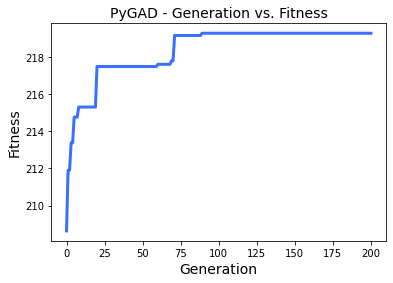

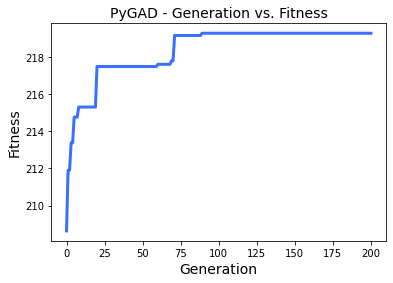

In [232]:
ga_instance.plot_fitness()

[ 0  0  0  7  3  0  8  6  0  5  4  2  8  4  1 10  6  8  9  3  9 10  8  9
  9  3  4  7  1  5  3  3  7  5  1 10 10  9  8  4  4  4  5  9  7  6  5  5
  6  8  5  1  3  9  2  4  5  2  0  7]
129.62